In [ ]:
!pip -q install scikit-learn tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

ROOT = "/content/drive/MyDrive/food-101/food-101"
IMG_DIR  = os.path.join(ROOT, "images")
META_DIR = os.path.join(ROOT, "meta")

TRAIN_TXT = os.path.join(META_DIR, "train.txt")
TEST_TXT  = os.path.join(META_DIR, "test.txt")

print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("META_DIR exists:", os.path.exists(META_DIR))
print("TRAIN_TXT exists:", os.path.exists(TRAIN_TXT))
print("TEST_TXT exists:", os.path.exists(TEST_TXT))

assert os.path.exists(IMG_DIR) and os.path.exists(TRAIN_TXT) and os.path.exists(TEST_TXT), " Path problem"


IMG_DIR exists: True
META_DIR exists: True
TRAIN_TXT exists: True
TEST_TXT exists: True


In [ ]:
def read_split_list(txt_path):
    with open(txt_path, "r") as f:
        return [line.strip() for line in f if line.strip()]

train_list = read_split_list(TRAIN_TXT)
test_list  = read_split_list(TEST_TXT)

print("Train listed:", len(train_list))
print("Test listed:", len(test_list))
print("Example item:", train_list[0])  # e.g. apple_pie/1005649


Train listed: 75750
Test listed: 25250
Example item: apple_pie/1005649


In [ ]:
import random
random.seed(42)

MAX_PER_CLASS = 80  #  change: 50 / 80 / 100 / 200

def limit_per_class(items, max_per_class):
    by_class = {}
    for item in items:
        cls = item.split("/")[0]
        by_class.setdefault(cls, []).append(item)

    limited = []
    for cls, imgs in by_class.items():
        random.shuffle(imgs)
        limited.extend(imgs[:max_per_class])
    return limited

train_small = limit_per_class(train_list, MAX_PER_CLASS)
test_small  = limit_per_class(test_list,  MAX_PER_CLASS)

print("Using Train:", len(train_small))
print("Using Test :", len(test_small))


Using Train: 8080
Using Test : 8080


In [ ]:
def to_image_path(item):
    return os.path.join(IMG_DIR, item + ".jpg")

X_train_paths = [to_image_path(x) for x in train_small]
y_train = [x.split("/")[0] for x in train_small]

X_test_paths = [to_image_path(x) for x in test_small]
y_test = [x.split("/")[0] for x in test_small]

print("Example:", X_train_paths[0], y_train[0])
print("File exists?", os.path.exists(X_train_paths[0]))


Example: /content/drive/MyDrive/food-101/food-101/images/apple_pie/3175105.jpg apple_pie
File exists? True


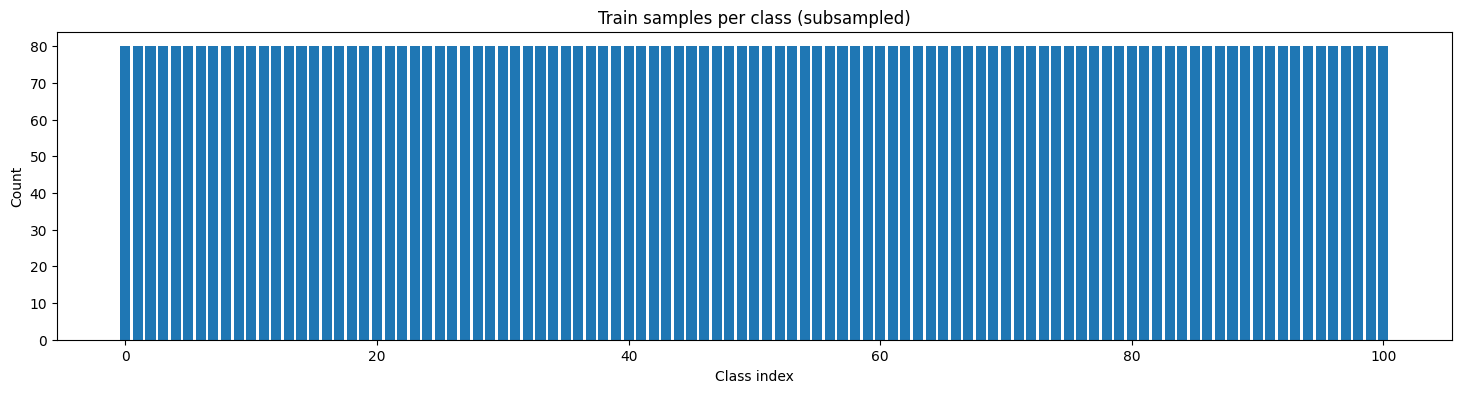

Top 10 class counts: [('apple_pie', 80), ('baby_back_ribs', 80), ('baklava', 80), ('beef_carpaccio', 80), ('beef_tartare', 80), ('beet_salad', 80), ('beignets', 80), ('bibimbap', 80), ('bread_pudding', 80), ('breakfast_burrito', 80)]


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

train_counts = Counter(y_train)

classes_sorted = sorted(train_counts.keys())
vals = [train_counts[c] for c in classes_sorted]

plt.figure(figsize=(18,4))
plt.bar(range(len(classes_sorted)), vals)
plt.title("Train samples per class (subsampled)")
plt.xlabel("Class index")
plt.ylabel("Count")
plt.show()

# Show top 10 classes by count (they should be equal if subsampling worked)
top10 = train_counts.most_common(10)
print("Top 10 class counts:", top10)


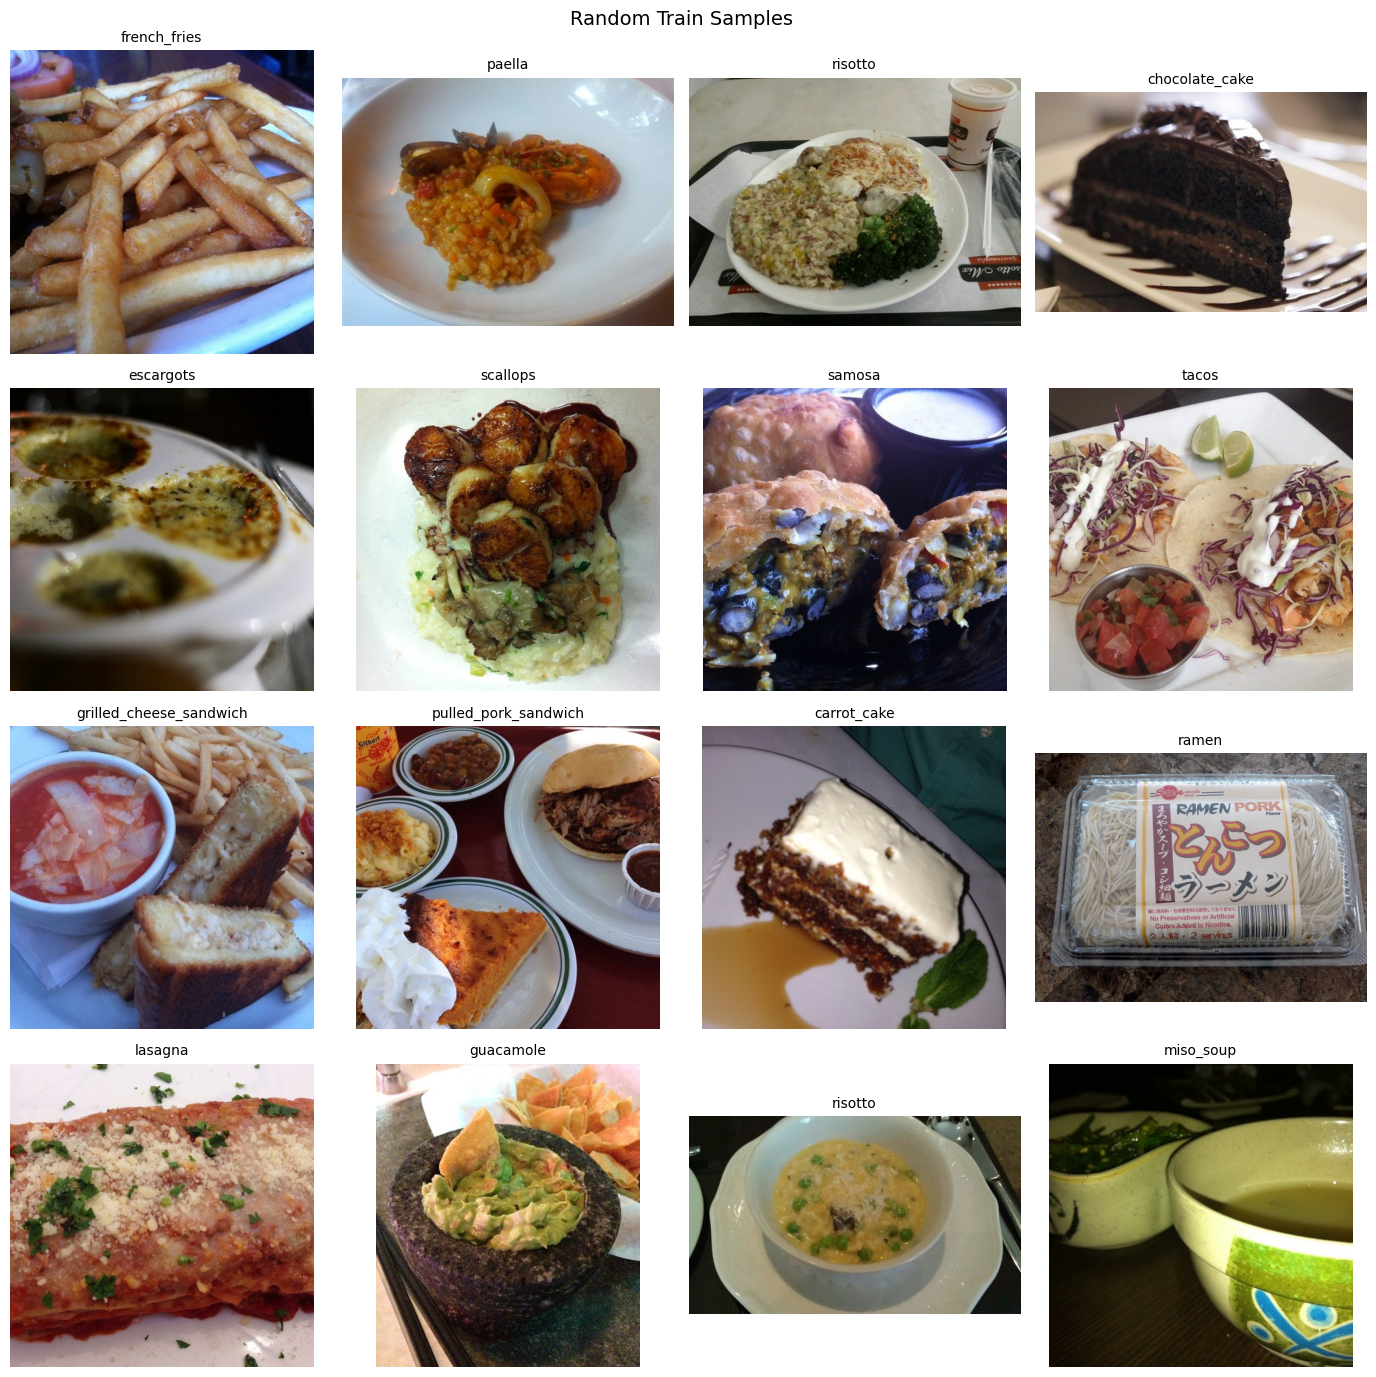

In [ ]:
from PIL import Image
import numpy as np

def show_image_grid(paths, labels, n=16, title="Sample Images"):
    pick = random.sample(range(len(paths)), k=min(n, len(paths)))
    cols = 4
    rows = int(np.ceil(len(pick)/cols))

    plt.figure(figsize=(14, 3.5*rows))
    for i, idx in enumerate(pick, 1):
        img = Image.open(paths[idx]).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(labels[idx], fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_image_grid(X_train_paths, y_train, n=16, title="Random Train Samples")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

IMG_SIZE = (224, 224)
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

print("Feature vector dim:", base_model.output_shape)  # (None, 1280)


/tmp/ipython-input-509458848.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature vector dim: (None, 1280)


In [ ]:
from tqdm import tqdm

CACHE_DIR = os.path.join(ROOT, "knn_cache")
os.makedirs(CACHE_DIR, exist_ok=True)

XTR_NPY = os.path.join(CACHE_DIR, f"X_train_feat_{MAX_PER_CLASS}.npy")
XTE_NPY = os.path.join(CACHE_DIR, f"X_test_feat_{MAX_PER_CLASS}.npy")
YTR_NPY = os.path.join(CACHE_DIR, f"y_train_{MAX_PER_CLASS}.npy")
YTE_NPY = os.path.join(CACHE_DIR, f"y_test_{MAX_PER_CLASS}.npy")

def extract_feature(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = base_model.predict(x, verbose=0)
    return feat[0]

if os.path.exists(XTR_NPY) and os.path.exists(XTE_NPY) and os.path.exists(YTR_NPY) and os.path.exists(YTE_NPY):
    print(" Loading cached features...")
    X_train_feat = np.load(XTR_NPY)
    X_test_feat  = np.load(XTE_NPY)
    y_train_arr  = np.load(YTR_NPY, allow_pickle=True)
    y_test_arr   = np.load(YTE_NPY, allow_pickle=True)
else:
    print("⏳ Extracting train features...")
    X_train_feat = np.array([extract_feature(p) for p in tqdm(X_train_paths)], dtype=np.float32)

    print("⏳ Extracting test features...")
    X_test_feat  = np.array([extract_feature(p) for p in tqdm(X_test_paths)], dtype=np.float32)

    y_train_arr = np.array(y_train, dtype=object)
    y_test_arr  = np.array(y_test, dtype=object)

    np.save(XTR_NPY, X_train_feat)
    np.save(XTE_NPY, X_test_feat)
    np.save(YTR_NPY, y_train_arr)
    np.save(YTE_NPY, y_test_arr)

print("Train features:", X_train_feat.shape)
print("Test features :", X_test_feat.shape)


⏳ Extracting train features...


100%|██████████| 8080/8080 [1:03:57<00:00,  2.11it/s]


⏳ Extracting test features...


100%|██████████| 8080/8080 [59:48<00:00,  2.25it/s]

Train features: (8080, 1280)
Test features : (8080, 1280)


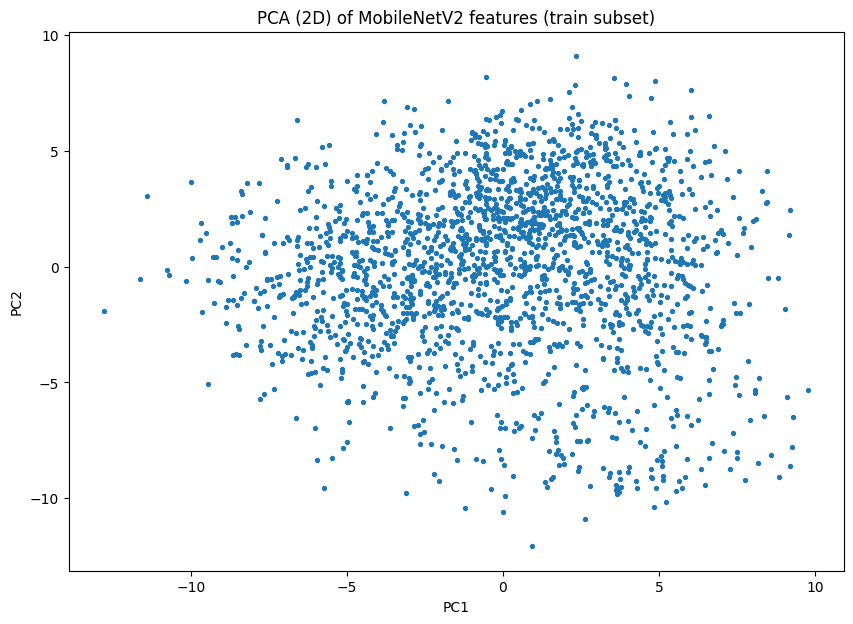

In [ ]:
from sklearn.decomposition import PCA

# Use a subset for plotting (PCA scatter can be heavy)
plot_n = min(2000, len(X_train_feat))
idx = np.random.choice(len(X_train_feat), size=plot_n, replace=False)

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_train_feat[idx])

plt.figure(figsize=(10,7))
plt.scatter(X2[:,0], X2[:,1], s=8)
plt.title("PCA (2D) of MobileNetV2 features (train subset)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


k=1 -> acc=0.3264
k=3 -> acc=0.3255
k=5 -> acc=0.3629
k=7 -> acc=0.3785
k=9 -> acc=0.3907
k=11 -> acc=0.3946


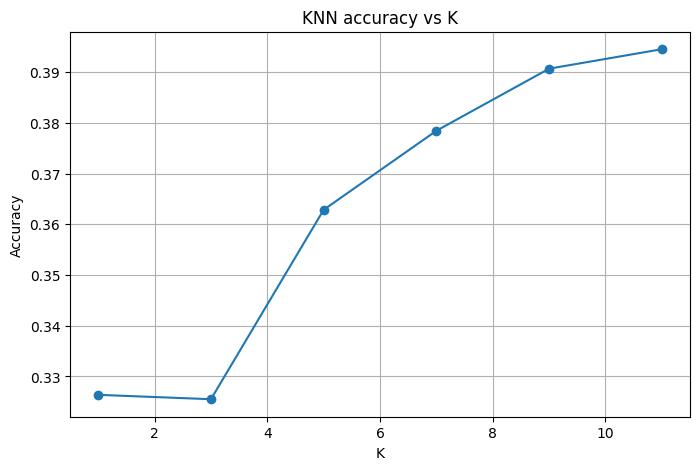

 Best k: 11


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Ks = [1, 3, 5, 7, 9, 11]
accs = []

for k in Ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", n_jobs=-1)
    knn.fit(X_train_feat, y_train_arr)
    pred = knn.predict(X_test_feat)
    acc = accuracy_score(y_test_arr, pred)
    accs.append(acc)
    print(f"k={k} -> acc={acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(Ks, accs, marker="o")
plt.title("KNN accuracy vs K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = Ks[int(np.argmax(accs))]
print(" Best k:", best_k)


In [ ]:
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=best_k, metric="euclidean", n_jobs=-1)
knn.fit(X_train_feat, y_train_arr)

y_pred = knn.predict(X_test_feat)

acc = accuracy_score(y_test_arr, y_pred)
print(" Final Accuracy:", acc)

print(classification_report(y_test_arr, y_pred, zero_division=0)[:2000])


 Final Accuracy: 0.39455445544554457
                         precision    recall  f1-score   support

              apple_pie       0.08      0.16      0.10        80
         baby_back_ribs       0.24      0.41      0.31        80
                baklava       0.25      0.49      0.33        80
         beef_carpaccio       0.30      0.42      0.35        80
           beef_tartare       0.19      0.31      0.24        80
             beet_salad       0.27      0.29      0.28        80
               beignets       0.46      0.70      0.56        80
               bibimbap       0.44      0.64      0.52        80
          bread_pudding       0.10      0.29      0.15        80
      breakfast_burrito       0.27      0.46      0.34        80
             bruschetta       0.26      0.21      0.23        80
           caesar_salad       0.35      0.60      0.44        80
                cannoli       0.69      0.28      0.39        80
          caprese_salad       0.24      0.20      0.

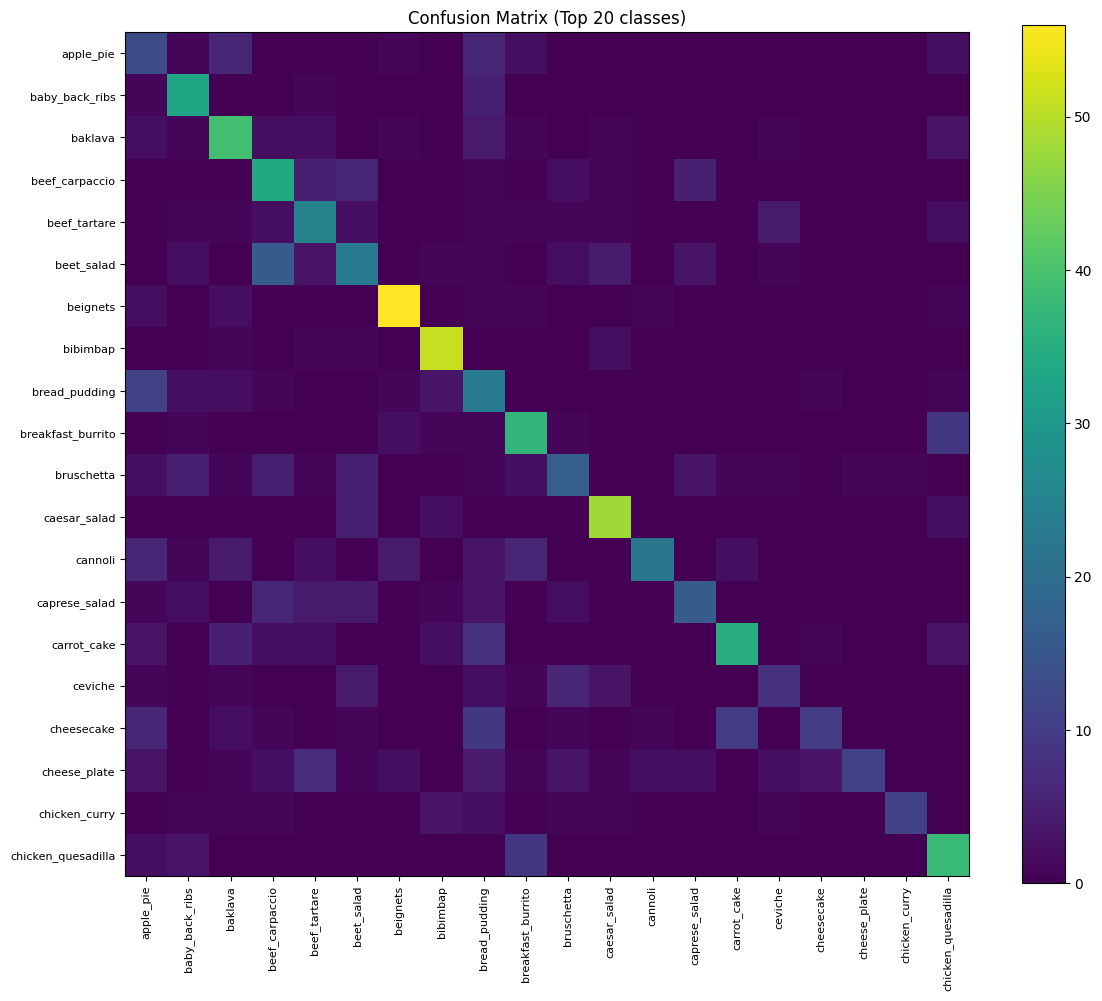

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

from collections import Counter
top_classes = [c for c,_ in Counter(y_test_arr).most_common(20)]

mask = np.isin(y_test_arr, top_classes)
yt = y_test_arr[mask]
yp = y_pred[mask]

cm = confusion_matrix(yt, yp, labels=top_classes)

plt.figure(figsize=(12,10))
plt.imshow(cm)
plt.title("Confusion Matrix (Top 20 classes)")
plt.xticks(range(len(top_classes)), top_classes, rotation=90, fontsize=8)
plt.yticks(range(len(top_classes)), top_classes, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()


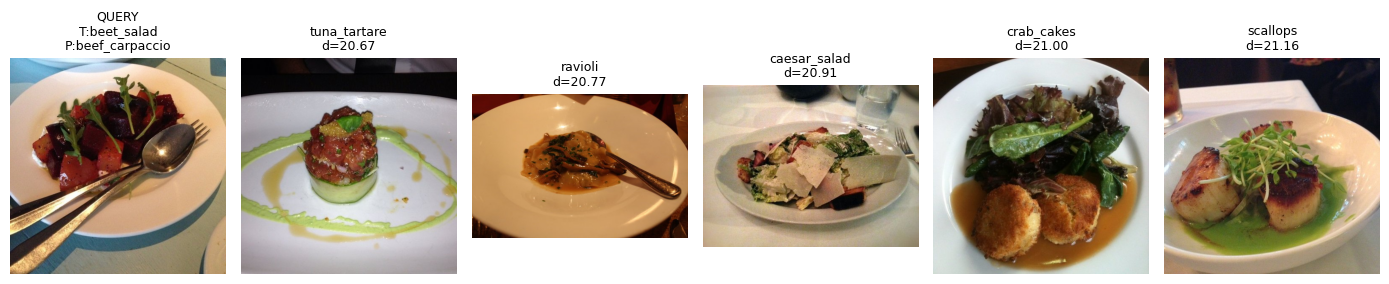

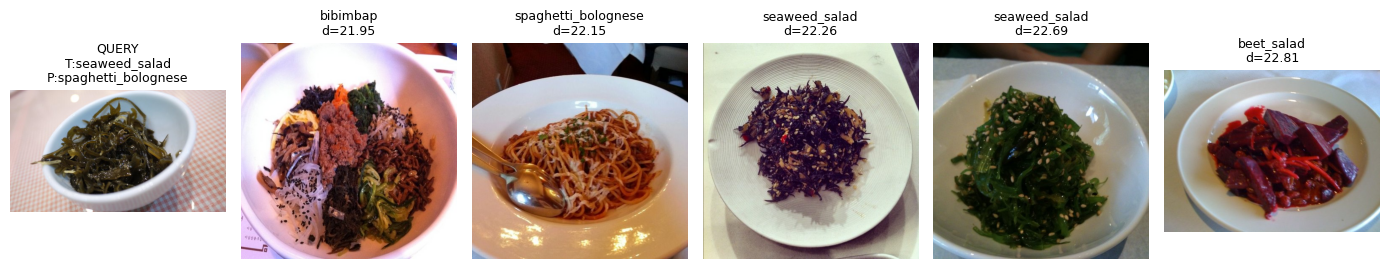

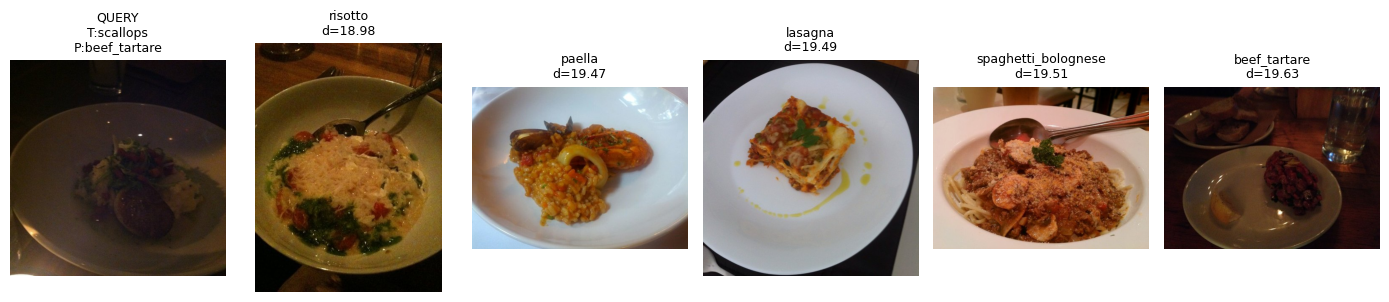

In [ ]:
def show_knn_neighbors(test_index, k=5):
    # distances + indices from KNN
    dists, inds = knn.kneighbors(X_test_feat[test_index:test_index+1], n_neighbors=k)
    inds = inds[0]
    dists = dists[0]

    # Show query image
    plt.figure(figsize=(14, 3))
    q_img = Image.open(X_test_paths[test_index]).convert("RGB")
    plt.subplot(1, k+1, 1)
    plt.imshow(q_img)
    plt.axis("off")
    plt.title(f"QUERY\nT:{y_test_arr[test_index]}\nP:{y_pred[test_index]}", fontsize=9)

    # Show neighbors
    for i, (tr_idx, dist) in enumerate(zip(inds, dists), 2):
        n_img = Image.open(X_train_paths[tr_idx]).convert("RGB")
        plt.subplot(1, k+1, i)
        plt.imshow(n_img)
        plt.axis("off")
        plt.title(f"{y_train_arr[tr_idx]}\nd={dist:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()

# Try a few random test images
for _ in range(3):
    ti = random.randrange(len(X_test_paths))
    show_knn_neighbors(ti, k=5)


Right: 3188 Wrong: 4892


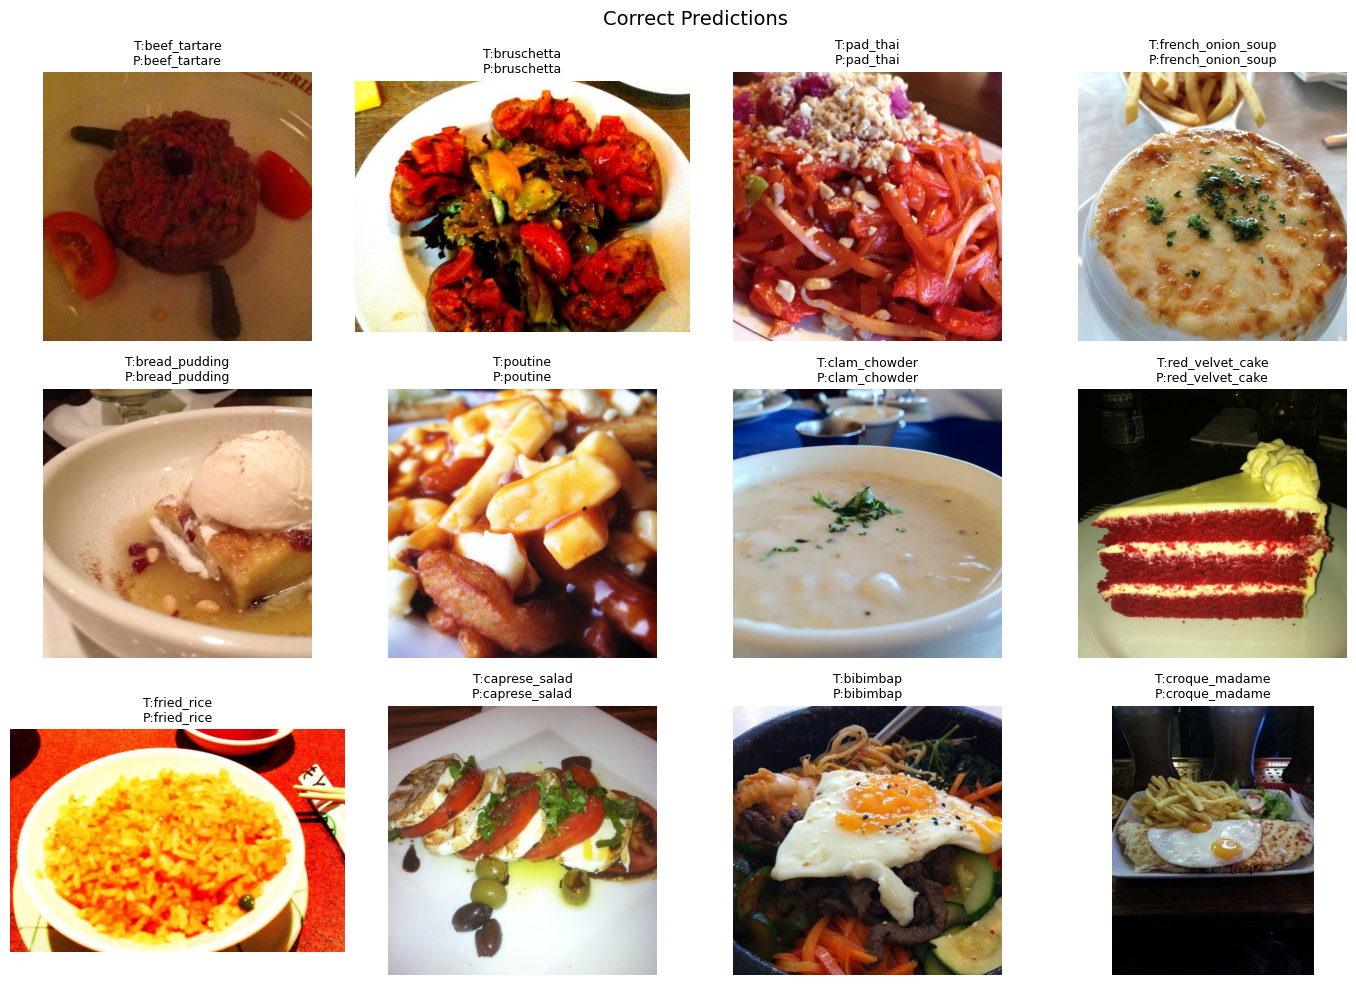

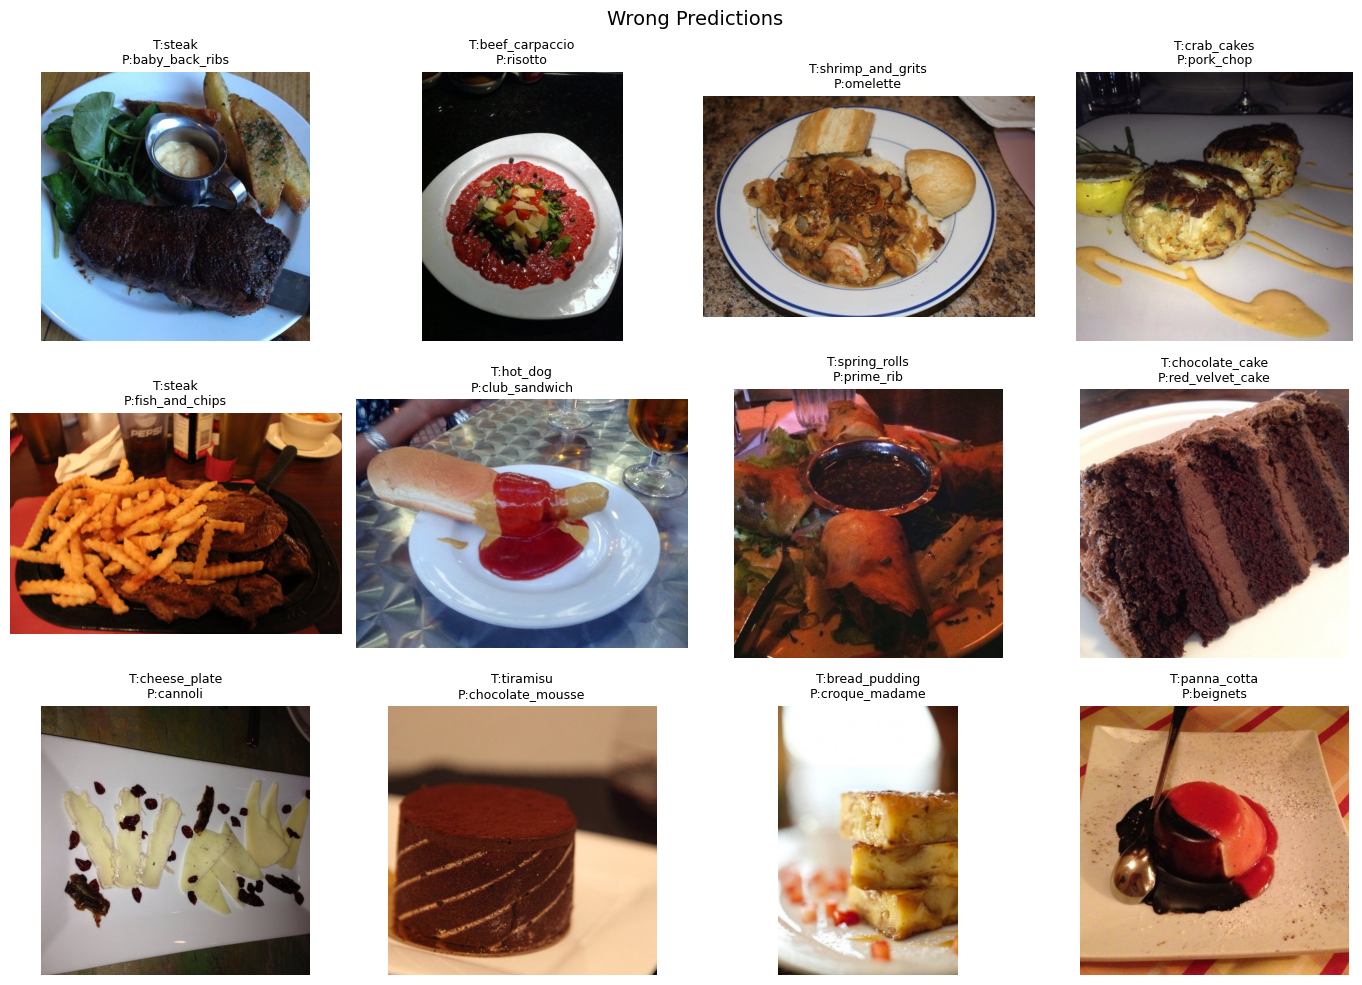

In [ ]:
wrong = np.where(y_pred != y_test_arr)[0]
right = np.where(y_pred == y_test_arr)[0]

print("Right:", len(right), "Wrong:", len(wrong))

def show_predictions(indices, title):
    plt.figure(figsize=(14, 10))
    cols = 4
    rows = int(np.ceil(len(indices)/cols))
    for i, idx in enumerate(indices, 1):
        img = Image.open(X_test_paths[idx]).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{y_test_arr[idx]}\nP:{y_pred[idx]}", fontsize=9)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# show 12 correct and 12 wrong (if available)
show_predictions(list(np.random.choice(right, size=min(12, len(right)), replace=False)), "Correct Predictions")
if len(wrong) > 0:
    show_predictions(list(np.random.choice(wrong, size=min(12, len(wrong)), replace=False)), "Wrong Predictions")
